# A grid of water filled boxes

We'll use a topography product and label boxes on a regular `lon`, `lat`, `z` grid based on whether they are filled with water or with rocks.

## Parameters

We want ot control the resolution of the target grid.  Be _careful_ not so set resolution too high!  (A resolution of one degree in lon and lat and of 500m in depth results in about 40 MB of CSV data in the end.)

In [1]:
# parameters
dlon = 1.0
dlat = 1.0
dz = 500.0

## Tech preamble

In [2]:
import xarray as xr

## Download and load ETOPO data

Note that this is not the original data source, but from the example datasets of _Ferret_ (an Ocean data analsysis product).

In [3]:
!curl ftp://ftp.pmel.noaa.gov/ferret/pub/data/etopo05.nc.Z -O
!gunzip -v etopo05.nc.Z

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12.8M  100 12.8M    0     0  1406k      0  0:00:09  0:00:09 --:--:-- 2645k
etopo05.nc.Z:	 63.9% -- replaced with etopo05.nc


In [4]:
etopo_dataset = xr.open_dataset("etopo05.nc")
etopo_dataset = etopo_dataset.rename(
    {
        "ETOPO05_X": "longitude",
        "ETOPO05_Y": "latitude",
        "ROSE": "z",
    }
)
etopo_dataset

<xarray.Dataset>
Dimensions:    (longitude: 4320, latitude: 2161)
Coordinates:
  * longitude  (longitude) float64 0.0 0.08333 0.1667 0.25 ... 359.8 359.8 359.9
  * latitude   (latitude) float64 -90.0 -89.92 -89.83 ... 89.83 89.92 90.0
Data variables:
    z          (latitude, longitude) float32 ...
Attributes:
    history:        FERRET V5.22   27-Apr-01, from IRI/LDEO worldbath.nc
    IRI_LDEO_note:  updated 27 Feb 1998 from NGDC CD-ROM 29 April 1993

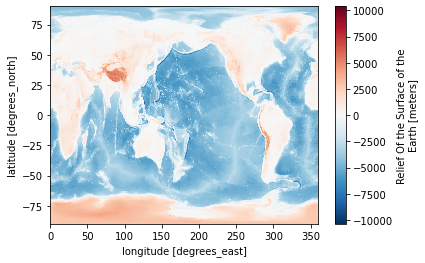

In [5]:
etopo_dataset.z.plot();

## Create desired grid

In [6]:
import numpy as np

In [7]:
# will be used a indexers (selectors?) for the etopo data
longitude = xr.DataArray(np.arange(0, 360, dlon), dims="longitude")  # 1 degree grid
latitude = xr.DataArray(np.arange(-90, 91, dlat), dims="latitude")  # 1 degree grid

# will be used to generate a boolean array which is True where water is present
z = xr.DataArray(
    np.arange(0, -10_000 - dz, -dz),
    dims="z",
    coords={"z": np.arange(0, -10_000 - dz, -dz)},
    name="z",
)  # 500m steps between -10_000 and 0 meters

In [8]:
z_etopo_at_grid = etopo_dataset.z.sel(
    longitude=longitude,
    latitude=latitude,
    method="nearest"
)
# make sure we label with the selectors
z_etopo_at_grid.coords["latitude"] = latitude
z_etopo_at_grid.coords["longitude"] = longitude
z_etopo_at_grid

<xarray.DataArray 'z' (latitude: 181, longitude: 360)>
array([[ 2810.,  2810.,  2810., ...,  2810.,  2810.,  2810.],
       [ 2804.,  2804.,  2804., ...,  2743.,  2743.,  2804.],
       [ 2743.,  2743.,  2743., ...,  2682.,  2682.,  2743.],
       ...,
       [-4404., -4416., -4424., ..., -4320., -4362., -4386.],
       [-4322., -4327., -4331., ..., -4300., -4309., -4316.],
       [-4290., -4290., -4290., ..., -4290., -4290., -4290.]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float64 -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
Attributes:
    long_name:  Relief Of the Surface of the Earth
    history:    From worldbath.nc
    units:      meters

In [9]:
water_filled = (z > z_etopo_at_grid).rename("water")
water_filled

<xarray.DataArray 'water' (z: 21, latitude: 181, longitude: 360)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
...
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * z          (z) float64 0.0 -500.0 -1e+03 -1.5e+03 ... -9e+03 -9.5e+03 -1e+04
  * longitude  (longitude) float64 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float64 -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0

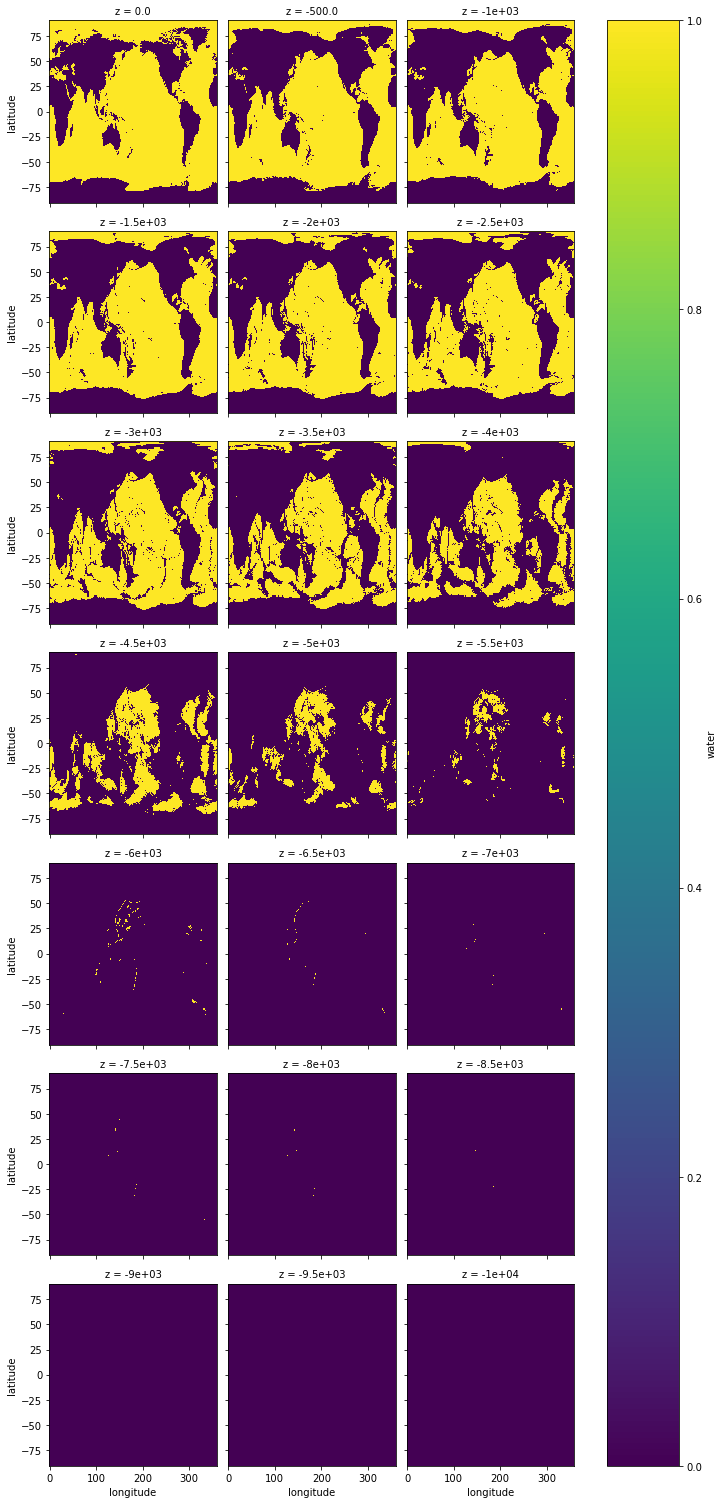

In [10]:
water_filled.plot(col="z", col_wrap=3)

## To netCDF

In [11]:
water_filled.to_dataset().to_netcdf("etopo05_water_filled_grid.nc")

## To CSV

In [12]:
water_filled.to_dataframe().reset_index().to_csv("etopo05_water_filled_grid.csv")